# Using `ncbi.datasets` library to download annotation and parse GFF3 files 

Here, we will use `ncbi.datasets` to download annotation data for some assemblies and parse them to extract specific information.  

Specifically, 
1. query NCBI for _Lactobacillus_ assemblies and download the assembly descriptors for all available assemblies
2. parse assembly descriptors to make a list of assemblies annotated in 2020
3. download genome sequence and annotation (gff3 and protein fasta) for those assemblies
4. parse gff3 files to extract information about crispr genes
  1. use that information to extract gene sequences from genome fasta files 
  2. use that information to extract protein sequences from protein fasta files 

## Setup
After importing the various python modules we will need, create the assembly and download API instances.

In [1]:
from collections import defaultdict, Counter
from datetime import datetime
import json
import os
from textwrap import dedent
import zipfile

import gffutils
import matplotlib.pyplot as plt
import ncbi.datasets
import pandas as pd
from pyfaidx import Fasta

plt.style.use('ggplot')

genome_api = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

## Group assemblies based on assembly annotation meta-data
Let's look at RefSeq *lactobacillus* assemblies, and see how we can use the annotation meta-data to organize the assembly data.

Using the `ncbi.datasets` library, we first check the number of available RefSeq *lactobacillus* assemblies.  When we use `limit='none'`, no descriptors are returned.

In [1]:
taxid = 1578 ## lactobacillus
assemblies_and_messages = genome_api.assembly_descriptors_by_taxon(
    taxon=taxid,
    limit='none',
    filters_refseq_only=True)

print(f"Number of assemblies: {descriptors.total_count}")

NameError: name 'descriptors' is not defined

Now that we know a reasonable number of assemblies are available, let's fetch all the data.  Be patient, this can take up to half a minute.

In [1]:
%%time
## download assembly descriptors for all of them
assemblies_and_messages = genome_api.assembly_descriptors_by_taxon(
    taxon=taxid,
    limit='all',
    filters_refseq_only=True)

CPU times: user 1.85 s, sys: 12.8 ms, total: 1.87 s
Wall time: 2.96 s


And then we can organize the assemblies by the year they were annotated, and plot the data.

<AxesSubplot:>

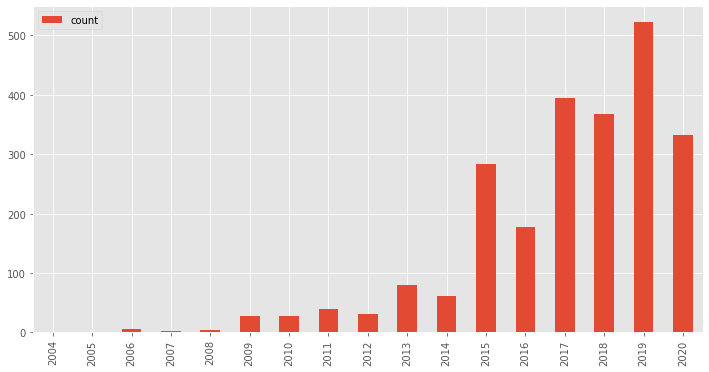

In [1]:
def annotation_year(annotation_metadata):
    return datetime.strptime(annotation_metadata.release_date, '%b %d, %Y').year

annots_by_year = Counter()
no_annot_assms = []
for d in map(lambda d: d.assembly, assemblies_and_messages.assemblies):
    if not d.annotation_metadata:
        no_annot_assms.append(d.assembly_accession)
        continue
    annots_by_year[annotation_year(d.annotation_metadata)] += 1


if len(no_annot_assms) > 0:
    print(dedent(f'''
    WARNING!
    Some assemblies do not have annotation. 
    Most likely, this is because of an indexing delay. Skipping {len(no_annot_assms)} assemblies.
'''))

df = pd.DataFrame.from_dict(annots_by_year, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(12,6))

Or, we can select just the assemblies that were annotated in 2020:

In [1]:
year_of_interest = 2020
assm_accs = []
for d in map(lambda d: d.assembly, assemblies_and_messages.assemblies):
    if d.annotation_metadata:
        if annotation_year(d.annotation_metadata) == year_of_interest:
            assm_accs.append(d.assembly_accession)
        
print(f'{len(assm_accs)} assemblies were annotated in {year_of_interest}.')

332 assemblies were annotated in 2020.


We could download all of the returned assemblies, based on the accessions stored in `assm_accs`.  If there are quite a few of them, a `download_api.download_assembly_package_post()` request would be required (see docs here)[https://github.com/ncbi/datasets/blob/master/client_docs/python/docs/DownloadApi.md#download_assembly_package_post]. 

For demonstration purposes, we'll just download the first five assemblies through a GET request.

In [1]:
%%time
## download data
print(f'Download first 5 accessions: {assm_accs[0:5]}')
dl_response = genome_api.download_assembly_package(
    assm_accs[0:5],
    include_sequence=True,
    include_annotation_type=['GENOME_GFF', 'PROT_FASTA'],
    _preload_content=False )

## write to a zip file 
zipfn = 'ncbi_genomes.zip'
with open(zipfn, 'wb') as f:
    f.write(dl_response.data)
print(f'Download complete: {zipfn}')
!unzip -l {zipfn}

Download first 5 accessions: ['GCF_012848655.1', 'GCF_013867605.1', 'GCF_013867555.1', 'GCF_013342945.1', 'GCF_012843665.1']
Download complete: ncbi_genomes.zip
Archive:  ncbi_genomes.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
      661  09-02-2020 13:09   README.md
  2243496  09-02-2020 13:09   ncbi_dataset/data/GCF_012843665.1/GCF_012843665.1_ASM1284366v1_genomic.fna
  1213074  09-02-2020 13:09   ncbi_dataset/data/GCF_012843665.1/genomic.gff
   796745  09-02-2020 13:09   ncbi_dataset/data/GCF_012843665.1/protein.faa
  1705083  09-02-2020 13:09   ncbi_dataset/data/GCF_012848655.1/GCF_012848655.1_ASM1284865v1_genomic.fna
   861530  09-02-2020 13:09   ncbi_dataset/data/GCF_012848655.1/genomic.gff
   589033  09-02-2020 13:09   ncbi_dataset/data/GCF_012848655.1/protein.faa
  2016963  09-02-2020 13:09   ncbi_dataset/data/GCF_013342945.1/GCF_013342945.1_ASM1334294v1_genomic.fna
  1008359  09-02-2020 13:09   ncbi_dataset/data/GCF_013342945.1/genomic.gff
   7158

In [1]:
## function to make list of files 
from ncbi.datasets.v1alpha1 import catalog_pb2
import pprint
pp = pprint.PrettyPrinter(indent=4)

def retrieve_data_catalog(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip:
        data_catalog = json.loads(zip.read('ncbi_dataset/data/dataset_catalog.json'))
    print(f"Catalog found with metadata for {len(data_catalog['assemblies'])} assemblies")
    return data_catalog

def get_assemblies(data_catalog):
    return [x['accession'] for x in data_catalog['assemblies']]

# Temporary hack to support GENOMIC_NUCLEOTIDE_FASTA & PROTEIN_FASTA 
# which will be present in the next release
def get_file_list(data_catalog, desired_filetype):
    desired_filetype = desired_filetype.upper()
    if desired_filetype not in catalog_pb2.File.FileType.keys():
        raise Exception(f'Filetype {desired_filetype} is invalid.')
    
    files = defaultdict(list)
    for asm in data_catalog['assemblies']:
        acc = asm['accession']
        for f in asm['files']:
            filepath = os.path.join('ncbi_dataset', 'data', f['filePath'])
            if f['fileType'] == 'FASTA' and desired_filetype in ('GENOMIC_NUCLEOTIDE_FASTA') and filepath.endswith('fna'):
                files[acc].append(filepath)
                continue
            if f['fileType'] == 'GFF3':
                if desired_filetype in ('PROTEIN_FASTA') and filepath.endswith('faa'):
                    files[acc].append(filepath)
                if desired_filetype in ('GFF3') and filepath.endswith('gff'):
                    files[acc].append(filepath)
                continue
            if f['fileType'] == desired_filetype:
                files[acc].append(filepath)
        
    return files

data_catalog = retrieve_data_catalog(zipfn)
print(f'Assemblies:')
print(', '.join(get_assemblies(data_catalog)))
for file_type in ['GFF3', 'FASTA', 'GENOMIC_NUCLEOTIDE_FASTA', 'PROTEIN_FASTA']:
    file_list = get_file_list(data_catalog, file_type)
    print(f'Files for type: {file_type}')
    pp.pprint(file_list)


Catalog found with metadata for 5 assemblies
Assemblies:
GCF_012843665.1, GCF_012848655.1, GCF_013342945.1, GCF_013867555.1, GCF_013867605.1
Files for type: GFF3
defaultdict(<class 'list'>,
            {   'GCF_012843665.1': [   'ncbi_dataset/data/GCF_012843665.1/genomic.gff'],
                'GCF_012848655.1': [   'ncbi_dataset/data/GCF_012848655.1/genomic.gff'],
                'GCF_013342945.1': [   'ncbi_dataset/data/GCF_013342945.1/genomic.gff'],
                'GCF_013867555.1': [   'ncbi_dataset/data/GCF_013867555.1/genomic.gff'],
                'GCF_013867605.1': [   'ncbi_dataset/data/GCF_013867605.1/genomic.gff']})
Files for type: FASTA
defaultdict(<class 'list'>, {})
Files for type: GENOMIC_NUCLEOTIDE_FASTA
defaultdict(<class 'list'>,
            {   'GCF_012843665.1': [   'ncbi_dataset/data/GCF_012843665.1/GCF_012843665.1_ASM1284366v1_genomic.fna'],
                'GCF_012848655.1': [   'ncbi_dataset/data/GCF_012848655.1/GCF_012848655.1_ASM1284865v1_genomic.fna'],
     

In [1]:
## setting up files and directories

## temporary files; will be deleted at the end
temp_dir = 'tempfiles'
temp_gff = temp_dir + '/temp.gff'
temp_fa = temp_dir + '/temp.fa'

!mkdir -p {temp_dir}

## final output files 
genes_fn = 'crispr_genes.fna'
prots_fn = 'crispr_proteins.faa'

In [1]:
def create_gff3_db(files_by_assembly, temp_file, zfh):
    '''
    create gff3 db in memory, per assembly
    okay for bacterial assemblies but use caution
    when parsing large assemblies like human
    '''

    db = {}
    for assembly_accession, files in files_by_assembly.items():
        with open(temp_file, 'wb') as f:
            for file in files:
                print(f'\tWrite {file} to {temp_file}')
                f.write(zfh.read(file))
            db[assembly_accession] = gffutils.create_db(
                temp_file,
                dbfn = ':memory:',
                force=True,
                keep_order=True,
                merge_strategy='merge',
                sort_attribute_values=True)


    return db


def combine_fasta(files_by_assembly, temp_file, zfh):
    '''
    Combine fasta for *all* FASTA files, nt & protein
    '''
    with open(temp_file, 'wb') as f:
        for assembly, files in files_by_assembly.items():
            for file in files:
                print(f'\tAppending {file} to {temp_file}')
                f.write(zfh.read(file))

    print(f'Create FASTA object for {temp_file}.')
    return Fasta(temp_file, read_long_names=False, duplicate_action='first')
    

def extract_genes(gff3_db, assemblies, desired_genes):
    crispr_order = defaultdict(list)
    crispr_genes = {}

    for assembly_accession in assemblies:
        for gene in gff3_db[assembly_accession].features_of_type('gene'):
            gene_name = gene.attributes.get('Name', None)[0]
            if gene_name[:4] not in desired_genes:
                continue
            gene_range = (gene.start, gene.end)
            prot_acc = None
            if gene.attributes['gene_biotype'][0] == 'protein_coding':
                cds = list(gff3_db[assembly_accession].children(gene, featuretype='CDS'))
                prot_acc = cds[0].attributes.get('protein_id', None)[0]

            crispr_genes[gene_name] = ([gene.chrom, gene.strand, gene_range, prot_acc])
            crispr_order[assembly_accession].append(gene_name)
    return crispr_genes, crispr_order

def write_fasta(fh, defline, content):
    fh.write('>' + defline + '\n')
    fh.write(content + '\n')

In [1]:
%%time
crispr_genes = set(['cas3', 'cse1', 'cse2', 'cas7', 'cas5', 'cas6', 'cas4', 'cas1', 'cas2', 'cas5', 'cas8', 'cas9', 'csn2'])


## create empty files to add data to
open(genes_fn, 'w').close()
open(prots_fn, 'w').close()

with zipfile.ZipFile(zipfn, 'r') as zfh:

    print('Create GFF3 Database')
    gff3_db = create_gff3_db(get_file_list(data_catalog, 'GFF3'), temp_gff, zfh)
    
    print(f'Extract crispr genes ({len(crispr_genes)} genes)')
    crispr_genes, crispr_order = extract_genes(gff3_db, get_assemblies(data_catalog), crispr_genes)
    print(f'Write genes to {genes_fn}')

    print('Create genomes object')
    genomes = combine_fasta(get_file_list(data_catalog, 'GENOMIC_NUCLEOTIDE_FASTA'), temp_fa, zfh)
    
    # Write all genes to genes_fn
    with open(genes_fn, 'w') as fh:
        for gene_name, gene_info in crispr_genes.items():
            chrom, strand, gene_range, prot_acc = gene_info
            reverse_complement = True if strand == '-' else False
            gene_fasta = genomes.get_seq(chrom, gene_range[0], gene_range[1], rc=reverse_complement)
            write_fasta(fh, f'{gene_fasta.fancy_name}|{gene_name}', gene_fasta.seq)

    print('Create proteome object')
    proteome = combine_fasta(get_file_list(data_catalog, 'PROTEIN_FASTA'), temp_fa, zfh)
    
    # Write protein FASTA for each CRISPR gene
    with open(prots_fn, 'w') as fh:
        for gene_name, gene_info in crispr_genes.items():
            chrom, strand, gene_range, prot_acc = gene_info
            if prot_acc is not None:
                prot_fasta = proteome[prot_acc][:]
                write_fasta(fh, f'{prot_fasta.name}|{gene_name}', prot_fasta.seq)


Create GFF3 Database
	Write ncbi_dataset/data/GCF_012843665.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_012848655.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_013342945.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_013867555.1/genomic.gff to tempfiles/temp.gff
	Write ncbi_dataset/data/GCF_013867605.1/genomic.gff to tempfiles/temp.gff
Extract crispr genes (12 genes)
Write genes to crispr_genes.fna
Create genomes object
	Appending ncbi_dataset/data/GCF_012843665.1/GCF_012843665.1_ASM1284366v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_012848655.1/GCF_012848655.1_ASM1284865v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_013342945.1/GCF_013342945.1_ASM1334294v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_013867555.1/GCF_013867555.1_ASM1386755v1_genomic.fna to tempfiles/temp.fa
	Appending ncbi_dataset/data/GCF_013867605.1/GCF_013867605.1_ASM1386760v1_genomic.fna to t

In [1]:
## order of crispr genes in various assemblies
for k,v in crispr_order.items():
    print(k, v)

GCF_012843665.1 ['cas2', 'cas3', 'cas5', 'cas7i', 'cas8a1', 'cas6', 'cas3', 'cas7e', 'cas5e', 'cas6e', 'cas1e', 'cas2e', 'cas6', 'cas10']
GCF_012848655.1 ['cas3', 'cas7e', 'cas5e', 'cas6e', 'cas1e', 'cas2e']
